In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import datasets
import transformers

from tqdm.notebook import tqdm


import torch
import torch.nn as nn
from transformers import AutoModel,AutoConfig
from torch.nn import MSELoss
from torch.utils.data import DataLoader
import torchmetrics
from torchmetrics.regression import R2Score
from transformers import AdamW
from transformers import get_scheduler

In [3]:
torch.cuda.empty_cache()

print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [4]:
modelpath = "zhihan1996/DNABERT-2-117M"

datapath  = '/home/minorai7/CapstoneProject_Guide-RNA/bert/DNABERT_2-main'

df_train = pd.read_csv(f"{datapath}/data01/data01/esp/train_esp_decoded.csv")
df_test = pd.read_csv(f"{datapath}/data01/data01/esp/test_esp_decoded.csv")

print(df_train.info())
print(df_train.head())

print(df_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52755 entries, 0 to 52754
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seq     52755 non-null  object 
 1   y       52755 non-null  float64
dtypes: float64(1), object(1)
memory usage: 824.4+ KB
None
                     seq         y
0  GTCCAGGCCCGACTTGAGAGA  0.568351
1  GGTCAAGGAAGTAGCAAAAGA  0.383513
2  ACTACCAACCATACACCGTGT  0.591863
3  GGATACTCCTAGAGCACCACA  0.407494
4  GGGCATGACCGACCCACCAGG  0.348747
(5862, 2)


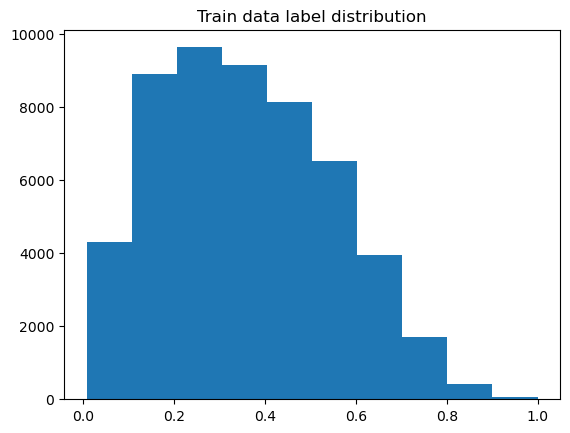

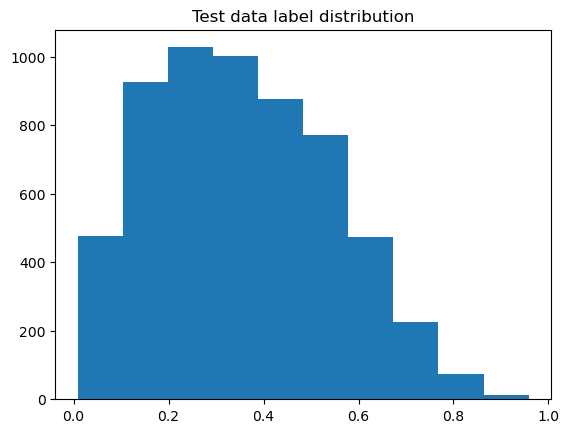

In [5]:
#plot label distribution of test and train data
plt.title("Train data label distribution")
plt.hist(df_train['y'])
plt.show()

plt.title("Test data label distribution")
plt.hist(df_test['y'])
plt.show()

In [6]:
#turn df into a dataset
raw_dataset_train = datasets.Dataset.from_pandas(df_train)
raw_dataset_test = datasets.Dataset.from_pandas(df_test)

print(raw_dataset_train)
print(raw_dataset_test)

Dataset({
    features: ['seq', 'y'],
    num_rows: 52755
})
Dataset({
    features: ['seq', 'y'],
    num_rows: 5862
})


In [7]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
        modelpath,
        
        model_max_length=100,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )

In [8]:
def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

tokenized_dataset_train = raw_dataset_train.map(tokenize_function, batched=True)
tokenized_dataset_train.set_format("torch")

print(tokenized_dataset_train)

tokenized_dataset_test = raw_dataset_test.map(tokenize_function, batched=True)
tokenized_dataset_test.set_format("torch")

print(tokenized_dataset_test)

Map:   0%|          | 0/52755 [00:00<?, ? examples/s]

Dataset({
    features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 52755
})


Map:   0%|          | 0/5862 [00:00<?, ? examples/s]

Dataset({
    features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5862
})


In [9]:
def clean_tokenized_dataset(dataset):
    dataset = dataset.remove_columns(["seq"])
    dataset = dataset.rename_column("y", "labels")
    dataset.set_format("torch")

    print(dataset.column_names)
    return dataset

tokenized_dataset_train = clean_tokenized_dataset(tokenized_dataset_train)
tokenized_dataset_test = clean_tokenized_dataset(tokenized_dataset_test)

print(tokenized_dataset_train)
print(tokenized_dataset_test)

['labels', 'input_ids', 'token_type_ids', 'attention_mask']
['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 52755
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5862
})


In [10]:
print(tokenizer.pad_token_id)
print(tokenizer.model_max_length)

data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding="longest", max_length=tokenizer.model_max_length)

3
100


In [11]:
batch_size = 512

train_dataloader = DataLoader(
    tokenized_dataset_train, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset_test, batch_size=batch_size, collate_fn=data_collator
)


In [12]:
from transformers import PreTrainedModel,AutoModel

class CustomModel(PreTrainedModel):
  config_class = AutoConfig

  def __init__(self, config): 
    super().__init__(config) 

    self.model = AutoModel.from_pretrained(
      modelpath,
      cache_dir=None,
      num_labels=1,
      trust_remote_code=True,
      ignore_mismatched_sizes=True)
    
    self.dropout = nn.Dropout(0.1) 
    self.classifier = nn.Linear(768, 1) # load and initialize weights

  def forward(self, input_ids=None, attention_mask=None,labels=None, token_type_ids=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state
    logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses
    #print(logits)

    loss = None
    if labels is not None:
      loss_fct = MSELoss()
      loss = loss_fct(logits.view(-1), labels.view(-1))
    
    return {"loss" : loss, "logits" : logits, "labels" : labels}

configpt = AutoConfig.from_pretrained(
    modelpath,
    trust_remote_code=True,
)

model = CustomModel(config=configpt)
model = model.cuda()

# for name, param in model.named_parameters():
#      if name.startswith("bert"): 
#         param.requires_grad = False

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.


Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


/home/minorai7/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/25abaf0bd247444fcfa837109f12088114898d98/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to b

In [13]:
model

CustomModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out_fea

In [14]:
for batch in train_dataloader:
    break
print({k: v.shape for k, v in batch.items()})

batch['labels'] = batch['labels'].to('cuda:0')
batch['input_ids'] = batch['input_ids'].to('cuda:0')
batch['token_type_ids'] = batch['token_type_ids'].to('cuda:0')
batch['attention_mask'] = batch['attention_mask'].to('cuda:0')


outputs = model(**batch)

#print(outputs)
print(outputs['loss'].shape, outputs['logits'].shape, outputs['labels'].shape)
#print(outputs.loss, outputs.logits.shape)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([512]), 'input_ids': torch.Size([512, 9]), 'token_type_ids': torch.Size([512, 9]), 'attention_mask': torch.Size([512, 9])}
torch.Size([]) torch.Size([512, 1]) torch.Size([512])


In [15]:
def compute_metrics(logits, labels):
    #reshape logits and labels
    logits = logits.view(-1)

    #calculate metrics using torchmetrics
    mse = torchmetrics.functional.mean_squared_error(logits, labels)
    rmse = torch.sqrt(mse)
    mae = torchmetrics.functional.mean_absolute_error(logits, labels)

    #spearmans rho
    rho = torchmetrics.functional.pearson_corrcoef(logits, labels)

    r2 = R2Score().to(device)(logits, labels)

    return {"mse": mse.item(), "rmse": rmse.item(), "mae": mae.item(), "r2": r2.item(), "rho": rho.item()}

In [16]:
optimizer = AdamW(model.parameters(), lr=3e-5)

/data/minorai7/condaenv/dnab311/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
num_epochs = 100
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

4160


In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [19]:
progress_bar = tqdm(range(num_training_steps))

evallist = []

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'Train Loss': loss.item()})
        progress_bar.update(1)
        


    model.eval()
    with torch.no_grad():
        batchevallist = []
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            batchevallist.append(compute_metrics(outputs['logits'], outputs['labels']))

    #calculate average metrics for the epoch
    epoch_metrics = {}
    for metricname in batchevallist[0].keys():
        epoch_metrics[metricname] = np.mean([x[metricname] for x in batchevallist])
    evallist.append(epoch_metrics)
    print(epoch_metrics)

  0%|          | 0/4160 [00:00<?, ?it/s]

{'mse': 0.03412385766083995, 'rmse': 0.18466012552380562, 'mae': 0.15487143645683923, 'r2': 0.010344753662745157, 'rho': 0.2256664571662744}
{'mse': 0.032340812496840954, 'rmse': 0.17976204554239908, 'mae': 0.1497828041513761, 'r2': 0.062044630448023476, 'rho': 0.3674452876051267}
{'mse': 0.027512056132157642, 'rmse': 0.16577029352386793, 'mae': 0.134128017971913, 'r2': 0.20245623091856638, 'rho': 0.4526142254471779}
{'mse': 0.027089816828568775, 'rmse': 0.16450796773036322, 'mae': 0.1342920164267222, 'r2': 0.21439935266971588, 'rho': 0.5446089059114456}
{'mse': 0.02360225406785806, 'rmse': 0.15352491413553557, 'mae': 0.12281833154459794, 'r2': 0.31564908226331073, 'rho': 0.6060925076405207}
{'mse': 0.021369616966694593, 'rmse': 0.14609776561458906, 'mae': 0.11605498629311721, 'r2': 0.38017577429612476, 'rho': 0.6439284930626551}
{'mse': 0.019205891372015078, 'rmse': 0.1385194088021914, 'mae': 0.10865963685015838, 'r2': 0.4428762545188268, 'rho': 0.6701914966106415}
{'mse': 0.018437924

In [20]:
datapath  = '/home/minorai7/CapstoneProject_Guide-RNA/bert/DNABERT_2-main'

# model.save_pretrained(f"{datapath}/models/testcustommodelsaved")

In [21]:
# conf2 = AutoConfig.from_pretrained(f"{datapath}/models/testcustommodelsaved", trust_remote_code=True)

# model = CustomModel.from_pretrained(f"{datapath}/models/testcustommodelsaved",
#                                     config=conf2,
#                                     trust_remote_code=True)
# model = model.cuda()

evallist = []

model.eval()
with torch.no_grad():
    batchevallist = []
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        batchevallist.append(compute_metrics(outputs['logits'], outputs['labels']))
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        batchevallist.append(compute_metrics(outputs['logits'], outputs['labels']))

#calculate average metrics for the epoch
epoch_metrics = {}
for metricname in batchevallist[0].keys():
    epoch_metrics[metricname] = np.mean([x[metricname] for x in batchevallist])
evallist.append(epoch_metrics)
print(epoch_metrics)

{'mse': 0.006691369561253694, 'rmse': 0.08053447286887415, 'mae': 0.06236950160357459, 'r2': 0.8080226789260733, 'rho': 0.9035531796258072}
